In [1]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
#from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
from gurobipy import *
from IPython.display import Audio
import os
import glob
import untangle

import xml.etree.ElementTree as et
import pandas as pd
import re
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import soundfile

# Functions

In [2]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency   
    return frequencies, abs(fourier_transform)

# TODO: Funktion überarbeiten damit man es auch versteht!
def new_fft(data, rate):
    N = len(data)

    # sample spacing
    T = 1.0 / rate
    x = np.linspace(0.0, N*T, N)

    yf = fft(data)
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2)
    ampl = 2.0/N * np.abs(yf[0:N//2])
    return freq, ampl

# Frequency domain representation
def plot_freq_domain(freq, fourier, name):
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1400)
    plt.title(name)
    plt.show()

# TODO: Warnung herausgeben wenn bei der Teilung der Samplerate eine Fliesskommazahl entsteht
def easy_downsampling(data, rate, sampl_fac):
    ds_data = []
    for i in range(len(data)):
        if (i%sampl_fac == 0):
            ds_data.append(data[i])
    ds_rate = int(rate/sampl_fac)
    return ds_data, ds_rate

#ToDo: startwert von 0 nicht möglich überarbeiten!!
def snip_wav(data, rate, start_sec, end_sec):
    start_point = int((rate * start_sec)-1)
    end_point = int((rate * end_sec)-1)
    #print('start_point:', start_point)
    #print('end_point:', end_point)
    snip_data = data[start_point:end_point]
    #print(snip_data)  
    return snip_data, rate

# Berechnung Vector target
#def calc_target_vec(pitch):
#    pitch_start = 40
#    #pitch_end = 76
#    pitch_end = pitch_start + 77 #TODO: muss angepasst werden
#    target_vec = []
#    
#    if pitch_start <= pitch <= pitch_end:
#        for pitch_act in range(pitch_start, pitch_end+1):
#            
#            if pitch_act == pitch:
#                target_vec.append(1)
#            else:
#                target_vec.append(0)
#    else:
#        print('Pitch muss innerhalb der Range({} - {})!'.format(pitch_start, pitch_end))
#    
#    return target_vec

def calc_target_vec(pitch):
    pitch_start = 40
    pitch_end = 76
    #pitch_end = pitch_start + 77 #TODO: muss angepasst werden
    combi_vec = []
    for element in pitch:
        pitch_vec = []
        if pitch_start <= element <= pitch_end:
            for pitch_act in range(pitch_start, pitch_end+1):
                if pitch_act == element:
                    pitch_vec.append(1)
                else:
                    pitch_vec.append(0)
            combi_vec.append(pitch_vec)
        else:
            print('Pitch muss innerhalb der Range({} - {})!'.format(pitch_start, pitch_end))
    target_vec = [sum(x) for x in zip(*combi_vec)]
    return target_vec

def metric(target_v, approx_v):
    norm_factor = np.linalg.norm(approx_v)
    if (norm_factor != 0):
        norm_v = approx_v/norm_factor
        diff = target_v - norm_v
        diff_sum = np.sum(np.abs(diff))
        return diff_sum
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return approx_v 
    
def norm_vec(vector):
    norm_factor = np.linalg.norm(vector)
    if (norm_factor != 0):
        norm_v = vector/norm_factor
        return norm_v
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return vector

## Dataframe 

In [3]:
def read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac):
    dataset = re.search(r'dataset.*\b', path).group(0)
    path_xml = path + "annotation"
    path_wav = path + "audio"  
    df = pd.DataFrame(columns=df_cols)
    
    for xml_file in sorted(glob.glob(os.path.join(path_xml, '*.xml'))):
        tree = et.parse(xml_file)
        root = tree.getroot()
        all_events = []
       
        for globalParam in root.findall('globalParameter'):
            audio_name = globalParam.find('audioFileName').text
            audio_name = audio_name.replace("\\", "")
            
            # Read wav-file
            wav_file = path_wav + '/' + audio_name
            data, rate = soundfile.read(wav_file)

        for transcription in root.findall('transcription'):

            for event in transcription.findall('event'):
                event_data = []
                event_data.append(dataset)
                event_data.append(audio_name)

                for elem in df_cols[len(event_data):]:
                    if event is not None:
                        if event.find(elem) is not None:
                            event_data.append(event.find(elem).text)
                            
                            if elem == 'onsetSec':
                                onsetSec = event.find(elem).text
                                start_sec = round(offset_sec + float(onsetSec), 3)
                                end_sec = round(start_sec + duration_sec, 3)

                                # Snip and downsampling audio-file
                                data_snip, rate_snip = snip_wav(data, rate, start_sec, end_sec)
                                data_down, rate_down = easy_downsampling(data_snip, rate_snip, sampl_fac)
                                
                                # Calc FFT
                                freq, fourier = new_fft(data_down, rate_down)
                                                       
                        elif elem == 'FFT':
                            event_data.append(fourier)

                        elif elem == 'Freq':
                            event_data.append(freq)
                        else:
                            event_data.append(None)
                    else:
                        event_data.append(None)

                all_events.append({df_cols[i]: event_data[i] for i, _ in enumerate(df_cols)})
                
        combi_events = mono_poly_detection(all_events)
        df = df.append(pd.DataFrame(combi_events, columns=df_cols), ignore_index=True)
        
    return df

In [4]:
def mono_poly_detection(events):
    
    poly_time = 0.070
    
    dataset = events[0]['dataset']
    audioFileName = events[0]['audioFileName']
    fft = events[0]['FFT']
    freq = events[0]['Freq']
    
    onsets = []
    pitches = []
    combi_events = []

    
    for event in events:
        onsets.append(float(event['onsetSec']))
        pitches.append(int(event['pitch']))
        
    pitch_array = [pitches[0]]
    new_onset = onsets[0]
    

    for i in range(len(events)-1):
        if (onsets[i + 1]- onsets[i]) <= poly_time:
            pitch_array.append(pitches[i+1])
            new_onset = onsets[i+1]
            fft = events[i+1]['FFT']
            freq = events[i+1]['Freq']
            
        else:
            combi_events.append({'dataset': dataset,
                               'audioFileName': audioFileName,
                               'pitch': pitch_array,
                               'onsetSec': new_onset,
                               'FFT': fft,
                               'Freq': freq,
                              })
            
            pitch_array = [pitches[i+1]]
            new_onset = onsets[i+1]
            fft = events[i+1]['FFT']
            freq = events[i+1]['Freq']
            
    combi_events.append({'dataset': dataset,
                   'audioFileName': audioFileName,
                   'pitch': pitch_array,
                   'onsetSec': new_onset,
                   'FFT': fft,
                   'Freq': freq,
                  })

    return combi_events

# Init Dataframe

In [5]:
# Set audio snippets and sample compression
offset_sec = 0.01
duration_sec = 0.03
sampl_fac = 4

# Create empty Dataframe
df_cols = ['dataset', 'audioFileName', 'pitch', 'onsetSec', 'FFT', 'Freq']
df_ref = pd.DataFrame(columns=df_cols)
df_test = pd.DataFrame(columns=df_cols)

# Create Dataframe with reference tones

In [6]:
%%time
# paths
path_main = "IDMT-SMT-GUITAR_V2/"
path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC/"
#path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC Chords/"

df_ref = read_xml_to_df(path_main_ref, df_cols, offset_sec, duration_sec, sampl_fac)
df_ref.head(10)
#df_ref.pitch

CPU times: user 431 ms, sys: 69.1 ms, total: 500 ms
Wall time: 755 ms


,dataset,audioFileName,pitch,onsetSec,FFT,Freq
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.0034458125826095165, 0.004362595487135711, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008083931268882175, 0.005238092712637641, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.009609625778889729, 0.011406250985680174, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.001399567480173716, 0.0014167871838317184, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.007340630015577794, 0.009544653537432508, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.011547814683251511, 0.015730345129751144, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
6,dataset1/Fender Strat Clean Neck SC,G53-45200-1111-00014.wav,[45],0.2,"[0.0015738219292862538, 0.0031928036782534414,...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
7,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.009288407524546828, 0.012464334077711213, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
8,dataset1/Fender Strat Clean Neck SC,G53-46201-1111-00015.wav,[46],0.2,"[0.0011633558935989427, 0.003730547465138663, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
9,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.01186460742777568, 0.010577410338592878, 0....","[0.0, 33.61280487804878, 67.22560975609755, 10..."


In [7]:
# drop duplicate in df_ref
df_ref_unique = pd.DataFrame(columns=df_cols)
 
for index, row in df_ref.iterrows():
    if not df_ref_unique.pitch.str.contains(row.pitch[0], regex=False).any():
        df_ref_unique = df_ref_unique.append(row, ignore_index=True)
df_ref_unique

,dataset,audioFileName,pitch,onsetSec,FFT,Freq
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.0034458125826095165, 0.004362595487135711, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008083931268882175, 0.005238092712637641, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.009609625778889729, 0.011406250985680174, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.001399567480173716, 0.0014167871838317184, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.007340630015577794, 0.009544653537432508, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.011547814683251511, 0.015730345129751144, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
6,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.009288407524546828, 0.012464334077711213, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
7,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.01186460742777568, 0.010577410338592878, 0....","[0.0, 33.61280487804878, 67.22560975609755, 10..."
8,dataset1/Fender Strat Clean Neck SC,G53-48108-1111-00009.wav,[48],0.2,"[0.0036964070760951663, 0.00217021824874803, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
9,dataset1/Fender Strat Clean Neck SC,G53-49109-1111-00010.wav,[49],0.2,"[0.002537476692314955, 0.0052495429268241195, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."


# Create Dataframe with testdatas

In [8]:
%%time
# paths testdata
# ToDO: Automatisieren #os.listdir(path_main + path_dataset)

path_testdata = [
    path_main + 'dataset1/Fender Strat Clean Neck SC/',
    path_main + 'dataset1/Fender Strat Clean Neck SC Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge+Neck SC/',
    path_main + 'dataset1/Ibanez Power Strat Clean Neck HU/',
    path_main + 'dataset2/']

# dataset2:
# [Errno 2] No such file or directory: 'IDMT-SMT-GUITAR_V2/dataset2/audio/\\AR_A_fret_1-20.wav'
# in xml file den audionamen angepasst AR_A_fret_1-20.wav --> AR_A_fret_0-20.wav
# Alle 0-20 und Lick11
# Gesamthaft mussten 27 von 261 XML-Dateien überarbeitet werden

for path in path_testdata[:2]:
    df_act = read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac)
    df_test = df_test.append(df_act, ignore_index=True)
df_test

CPU times: user 735 ms, sys: 59.1 ms, total: 794 ms
Wall time: 958 ms


,dataset,audioFileName,pitch,onsetSec,FFT,Freq
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.200,"[0.0034458125826095165, 0.004362595487135711, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.200,"[0.0008083931268882175, 0.005238092712637641, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.200,"[0.009609625778889729, 0.011406250985680174, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.200,"[0.001399567480173716, 0.0014167871838317184, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.200,"[0.007340630015577794, 0.009544653537432508, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
...,...,...,...,...,...,...
117,dataset1/Fender Strat Clean Neck SC Chords,4-A2-Minor 06.wav,"[51, 58, 63, 66, 70]",0.270,"[0.0016870412221487916, 0.003195209393700363, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
118,dataset1/Fender Strat Clean Neck SC Chords,4-A2-Minor 07.wav,"[52, 59, 64, 67, 71]",0.267,"[0.0028981557425415408, 0.003430485933009648, ...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
119,dataset1/Fender Strat Clean Neck SC Chords,4-A2-Minor 08.wav,"[53, 60, 65, 68, 72]",0.264,"[0.007972187145959214, 0.010154394768224785, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
120,dataset1/Fender Strat Clean Neck SC Chords,4-A2-Minor 09.wav,"[54, 61, 66, 69, 73]",0.282,"[0.0057822973706571, 0.007366317415056515, 0.0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."


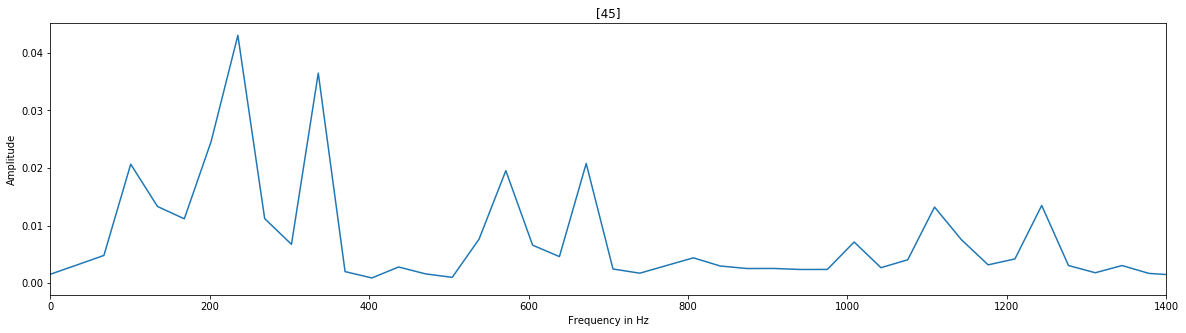

In [9]:
pitch = 6
plot_freq_domain(df_ref.Freq[pitch], df_ref.FFT[pitch], df_ref.pitch[pitch])

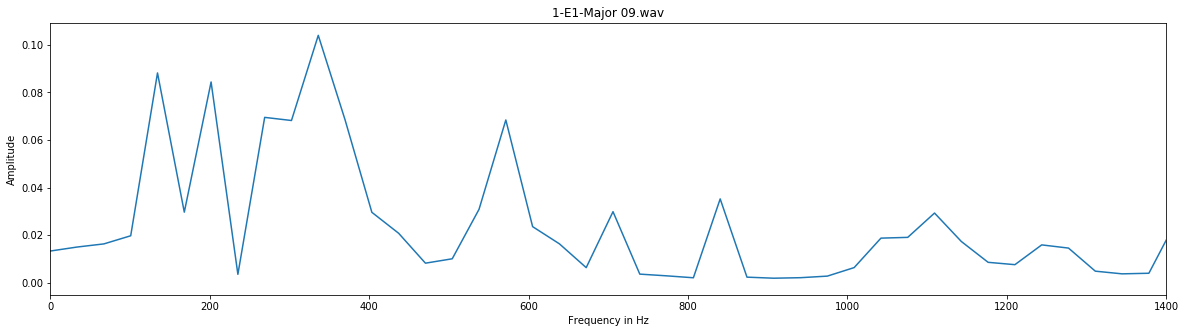

In [10]:
pitch = 87
plot_freq_domain(df_test.Freq[pitch], df_test.FFT[pitch], df_test.audioFileName[pitch])

# Gurobi

In [11]:
# Build Model
m = Model('AMt')

lambs = []
for lamb in range(len(df_ref_unique)):
    lambs.append(m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
m.update()

Academic license - for non-commercial use only


In [12]:
'''
%%time
#Optimize Signal

deviation = 0
approxi_sgn = 0
 
for sgn in range(len(mischsignal)):
#for sgn in range(100):
    for lamb in range(len(lambs)):
        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]
        
    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))
    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'
    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden
    # Überprüfen ob der Betrag der Differenz besser geeignet ist?
print('Deviation is calculated.')
'''

"\n%%time\n#Optimize Signal\n\ndeviation = 0\napproxi_sgn = 0\n \nfor sgn in range(len(mischsignal)):\n#for sgn in range(100):\n    for lamb in range(len(lambs)):\n        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]\n        \n    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))\n    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'\n    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden\n    # Überprüfen ob der Betrag der Differenz besser geeignet ist?\nprint('Deviation is calculated.')\n"

In [13]:
%%time
vec_pred = []

for index, row in df_test.iterrows():
    mischsignal = row.FFT
    #print(row.audioFileName)


    # Schlaufen vertauscht
    cost_function = 0
    approxi_sgn = 0

    for lamb in range(len(lambs)):
        la = lambs[lamb]
        #print('la:', la)
        #note = ref_note[lamb]['fourier']
        note = df_ref_unique.FFT[lamb]

        for sgn in range(len(mischsignal)):
            approxi_sgn = la * note[sgn]
            mi = mischsignal[sgn]
            cost_function += ((mi - approxi_sgn)*(mi - approxi_sgn))
    #print('Cost Function is created')

    m.params.outputflag = 0 # Infotext ausblenden
    m.setObjective(cost_function, GRB.MINIMIZE)
    m.optimize()



    approx_v = []

    for v in m.getVars():
        #print('%s: %g' % (v.varName, v.x))
        approx_v.append(v.x)

    vec_pred.append(approx_v)

CPU times: user 51.9 s, sys: 149 ms, total: 52 s
Wall time: 52.3 s


In [14]:
df_test['Vec_Pred'] = vec_pred

# Calculate Pitch Score

In [15]:
# Calc all target vectors
target_pitches = df_test.pitch.array
target_vec = []

for pitch in target_pitches:
    target_vec.append(calc_target_vec(pitch))

df_test['Vec_Target'] = target_vec
df_test.head()

,dataset,audioFileName,pitch,onsetSec,FFT,Freq,Vec_Pred,Vec_Target
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.0034458125826095165, 0.004362595487135711, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[1.000000000000001, 0.8516496107785423, 0.8769...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008083931268882175, 0.005238092712637641, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.8387454681762534, 1.0000000000000013, 0.929...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.009609625778889729, 0.011406250985680174, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.5939341502205836, 0.6389020779021982, 1.000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.001399567480173716, 0.0014167871838317184, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.4840196112534764, 0.6976988536352277, 0.998...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.007340630015577794, 0.009544653537432508, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.6531159684649682, 0.7779234627660159, 1.059...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
len(df_test.Vec_Pred[1])

37

In [17]:
pitch_score = []
vec_target = df_test.pitch.array

for vec in range(len(vec_pred)):
    pitch_score.append(metric(target_vec[vec], vec_pred[vec]))
    
df_test['Pitch_Score'] = pitch_score
df_test.head()

,dataset,audioFileName,pitch,onsetSec,FFT,Freq,Vec_Pred,Vec_Target,Pitch_Score
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.0034458125826095165, 0.004362595487135711, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[1.000000000000001, 0.8516496107785423, 0.8769...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.723690
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008083931268882175, 0.005238092712637641, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.8387454681762534, 1.0000000000000013, 0.929...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.773741
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.009609625778889729, 0.011406250985680174, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.5939341502205836, 0.6389020779021982, 1.000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.658635
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.001399567480173716, 0.0014167871838317184, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.4840196112534764, 0.6976988536352277, 0.998...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.404650
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.007340630015577794, 0.009544653537432508, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.6531159684649682, 0.7779234627660159, 1.059...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.707703


# Calculate F1 Score

In [18]:
# thresholding vec_pred
%time
vec_pred_thresh = []
v_pred = df_test.Vec_Pred
for ind in range(len(v_pred)):
    vec_thresh = []
    vec = norm_vec(v_pred[ind])
    for i in range(len(vec)):
        if vec[i]> 0.22:
            vec_thresh.append(1)
        else:
            vec_thresh.append(0)
    vec_pred_thresh.append(vec_thresh)
df_test['Thresholded'] = vec_pred_thresh
df_test.head()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs


,dataset,audioFileName,pitch,onsetSec,FFT,Freq,Vec_Pred,Vec_Target,Pitch_Score,Thresholded
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.0034458125826095165, 0.004362595487135711, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[1.000000000000001, 0.8516496107785423, 0.8769...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.723690,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008083931268882175, 0.005238092712637641, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.8387454681762534, 1.0000000000000013, 0.929...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.773741,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.009609625778889729, 0.011406250985680174, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.5939341502205836, 0.6389020779021982, 1.000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.658635,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.001399567480173716, 0.0014167871838317184, ...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.4840196112534764, 0.6976988536352277, 0.998...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.404650,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.007340630015577794, 0.009544653537432508, 0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.6531159684649682, 0.7779234627660159, 1.059...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.707703,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [19]:
target_vecs = []
for i in df_test.Vec_Target:
    for elem in i:
        target_vecs.append(elem)
#print(target_vecs)

pred_vecs = []
for i in df_test.Thresholded:
    for elem in i:
        pred_vecs.append(elem)
#print(pred_vecs)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(target_vecs,pred_vecs))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4194
           1       0.19      0.38      0.26       320

    accuracy                           0.85      4514
   macro avg       0.57      0.63      0.59      4514
weighted avg       0.90      0.85      0.87      4514

